<!-- ---
title: "Week 6"
title-block-banner: true
title-block-style: default
execute:
  freeze: true
  cache: true
format: html
# format: pdf
--- -->

In [1]:
dir <- "~/work/courses/stat380/weeks/week-12/"
# renv::activate(dir)


#### Packages we will require this week

In [241]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "repr",
    "tidyverse",
    "kableExtra",
    "IRdisplay",
    "car",
    "corrplot",
    # NEW
    "torch",
    "torchvision",
    "luz",
    # Dimension reduction
    "dimRed",
    "RSpectra"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

ISLR2       dplyr       tidyr       readr       purrr        repr 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
  tidyverse  kableExtra   IRdisplay         car    corrplot       torch 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
torchvision         luz      dimRed    RSpectra 
       TRUE        TRUE        TRUE        TRUE

---

# Tue, Apr 12

### Agenda:

1. Real-world neural network classification
1. Dataloaders
1. Torch for image classification

<br><br><br>

## Titanic

In [4]:
url <- "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

df <- read_csv(url) %>%
    mutate_if(\(x) is.character(x), as.factor) %>%
    mutate(y = Survived) %>%
    select(-c(Name, Survived)) %>%
    (\(x) {
        names(x) <- tolower(names(x))
        x
    })

df %>% head

Rows: 887 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Name, Sex
dbl (6): Survived, Pclass, Age, Siblings/Spouses Aboard, Parents/Children Ab...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pclass,sex,age,siblings/spouses aboard,parents/children aboard,fare,y
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,male,22,1,0,7.2500,0
1,female,38,1,0,71.2833,1
3,female,26,0,0,7.9250,1
1,female,35,1,0,53.1000,1
3,male,35,0,0,8.0500,0
3,male,27,0,0,8.4583,0


## Breast Cancer Prediction

In [5]:
# url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# col_names <- c("id", "diagnosis", paste0("feat", 1:30))

# df <- read_csv(
#         url, col_names, col_types = cols()
#     ) %>% 
#     select(-id) %>% 
#     mutate(y = ifelse(diagnosis == "M", 1, 0)) %>%
#     select(-diagnosis)


# df %>% head

### Train/Test Split

In [6]:
k <- 5

test_ind <- sample(
    1:nrow(df), 
    floor(nrow(df) / k),
    replace=FALSE
)

In [7]:
df_train <- df[-test_ind, ]
df_test  <- df[test_ind, ]

nrow(df_train) + nrow(df_test) == nrow(df)

[1] TRUE

### Benchmark with Logistic Regression

In [8]:
fit_glm <- glm(
    y ~ ., 
    df_train %>% mutate_at("y", factor), 
    family = binomial()
)

glm_test <- predict(
    fit_glm, 
    df_test,
    output = "response"
)

glm_preds <- ifelse(glm_test > 0.5, 1, 0)
table(glm_preds, df_test$y)

         
glm_preds   0   1
        0 103  16
        1  14  44

### Neural Net Model

In [9]:
NNet <- nn_module(
  initialize = function(p, q1, q2, q3) {  
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$output <- nn_linear(q3, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
    
  forward = function(x) {
    x %>% 
      self$hidden1() %>% self$activation() %>% 
      self$hidden2() %>% self$activation() %>% 
      self$hidden3() %>% self$activation() %>% 
      self$output() %>% self$sigmoid()
  }
)

### Fit using Luz

In [10]:
M <- model.matrix(y ~ 0 + ., data = df_train)

In [11]:
fit_nn <- NNet %>%
    #
    # Setup the model
    #
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adagrad, 
        metrics = list(
            luz_metric_accuracy()
        )
    ) %>% 
    #
    # Set the hyperparameters
    #
    set_hparams(p=ncol(M), q1=256, q2=128, q3=64) %>% 
    set_opt_hparams(lr=1e-2) %>% 
    #
    # Fit the model
    #
    fit(
        data = list(
            model.matrix(y ~ 0 + ., data = df_train),
            df_train %>% select(y) %>% as.matrix
        ),
        valid_data = list(
            model.matrix(y ~ 0 + ., data = df_test),
            df_test %>% select(y) %>% as.matrix
        ),
        epochs = 50, 
        verbose = TRUE
    )

Epoch 1/50
Train metrics: Loss: 1.0413 - Acc: 12.5634
Valid metrics: Loss: 0.7392 - Acc: 10.4237
Epoch 2/50
Train metrics: Loss: 0.6242 - Acc: 12.6
Valid metrics: Loss: 0.6216 - Acc: 10.4237
Epoch 3/50
Train metrics: Loss: 0.5953 - Acc: 12.6732
Valid metrics: Loss: 0.6009 - Acc: 10.4237
Epoch 4/50
Train metrics: Loss: 0.5986 - Acc: 12.6366
Valid metrics: Loss: 0.6021 - Acc: 10.4237
Epoch 5/50
Train metrics: Loss: 0.59 - Acc: 12.5634
Valid metrics: Loss: 0.6493 - Acc: 10.4237
Epoch 6/50
Train metrics: Loss: 0.5836 - Acc: 12.6366
Valid metrics: Loss: 0.5814 - Acc: 10.4237
Epoch 7/50
Train metrics: Loss: 0.5734 - Acc: 12.6732
Valid metrics: Loss: 0.5757 - Acc: 10.4237
Epoch 8/50
Train metrics: Loss: 0.5658 - Acc: 12.5634
Valid metrics: Loss: 0.5977 - Acc: 10.4237
Epoch 9/50
Train metrics: Loss: 0.5679 - Acc: 12.6
Valid metrics: Loss: 0.5659 - Acc: 10.4237
Epoch 10/50
Train metrics: Loss: 0.5555 - Acc: 12.6366
Valid metrics: Loss: 0.5638 - Acc: 10.4237
Epoch 11/50
Train metrics: Loss: 0.55

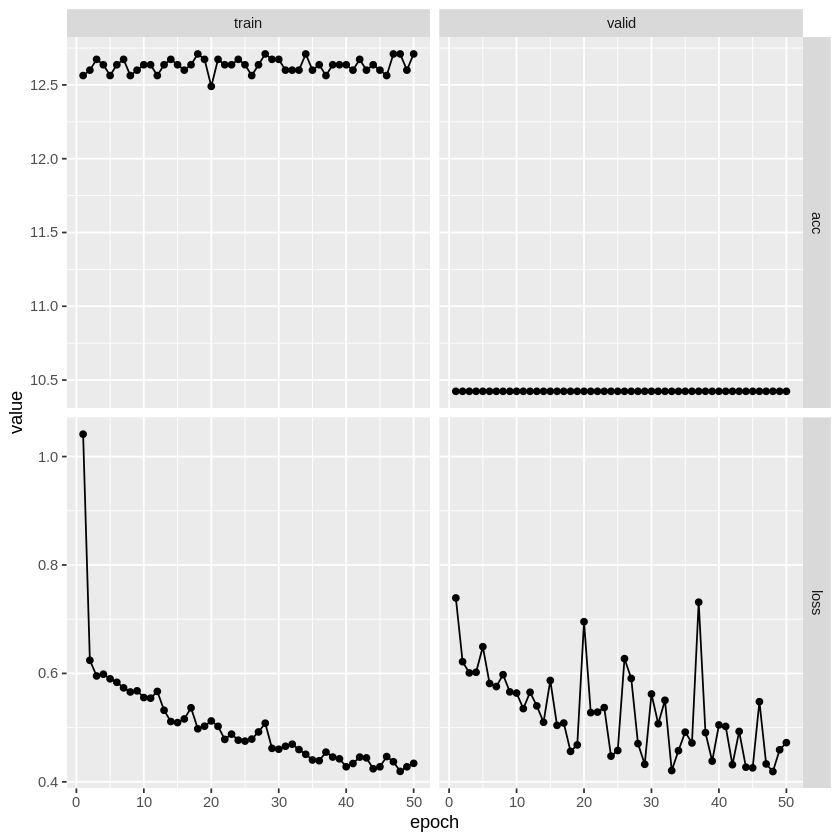

In [12]:
plot(fit_nn)

In [13]:
nn_test <- predict(
    fit_nn, 
    model.matrix(y ~ . - 1, data = df_test)
)
# nn_test
nn_preds <- ifelse(nn_test > 0.5, 1, 0)

table(nn_preds, df_test$y)
mean(nn_preds == df_test$y)

        
nn_preds   0   1
       0 109  30
       1   8  30

[1] 0.7853107

In [14]:
table(glm_preds, df_test$y)
mean(glm_preds == df_test$y)

         
glm_preds   0   1
        0 103  16
        1  14  44

[1] 0.8305085

<br><br><br><br>

---

### DataLoaders

* Dataloaders are a key component in the machine learning pipeline.

* They handle loading and preprocessing data in a way that is efficient for training and evaluating models.

* Dataloaders make it easy to work with large datasets by loading the data in smaller chunks (called **batches**) and applying transformations _on-the-fly_.


##### Why use Dataloaders?

> * **Efficient memory management:** loading data in smaller chunks reduces memory usage.
>
> * **Parallelism:**  supports asynchronous data loading for faster processing.
>
> * **Preprocessing:**  apply data transformations on-the-fly during training and evaluation.
>
> * **Flexibility:**  easily switch between different datasets or preprocessing steps.
>
> * **Standardization:**  consistent data format across various machine learning projects.
>

In [15]:
# ?dataloader

In [16]:
transform <- function(x) x %>% 
    torch_tensor() %>% 
    torch_flatten() %>% 
    torch_div(255)

In [467]:
dir <- "./mnist"

train_ds <- mnist_dataset(
  dir,
  download = TRUE,
  transform = transform
)

test_ds <- mnist_dataset(
  dir,
  download = TRUE,
  train = FALSE,
  transform = transform
)

In [468]:
typeof(train_ds)
length(train_ds)
train_ds$data[42000, ,]

[1] "environment"

[1] 60000

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,42,218,134,186,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,27,221,253,252,221,16,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,16,190,253,252,252,108,0,0,0
0,0,0,0,0,0,0,0,1,109,⋯,0,0,0,109,252,236,62,0,0,0
0,0,0,0,0,0,0,0,125,252,⋯,0,0,0,109,252,215,42,0,0,0
0,0,0,0,0,0,0,0,62,189,⋯,0,0,21,212,252,241,221,0,0,0


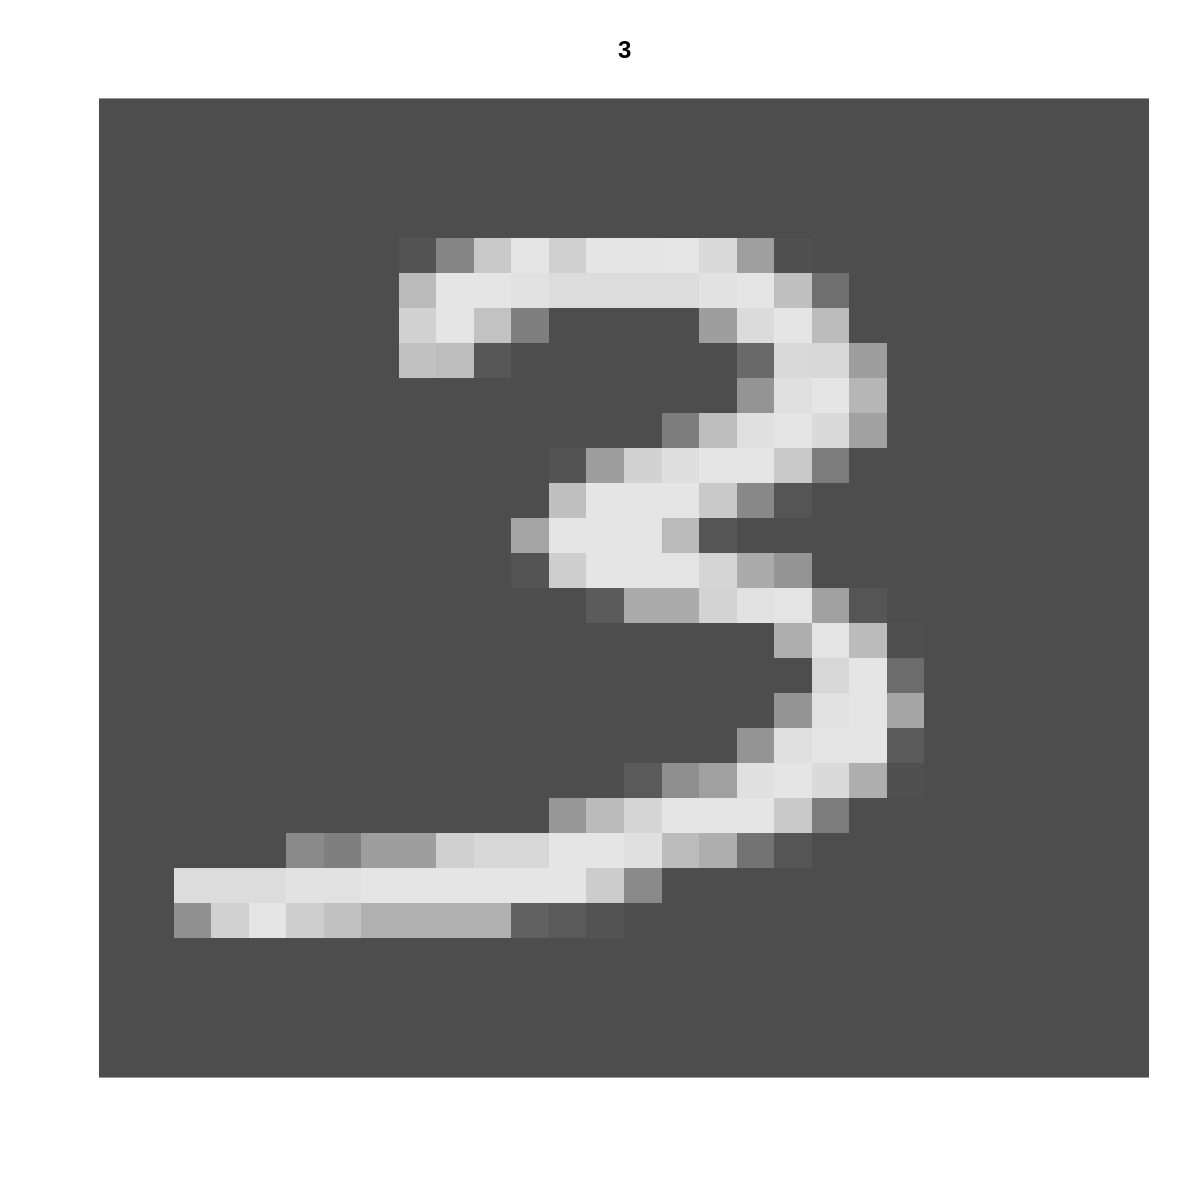

In [19]:
options(repr.plot.width=10, repr.plot.height=10)

i <- sample(1:length(train_ds), 1)
x <- train_ds$data[i, ,] %>% t

image(x[1:28, 28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000), main = train_ds$targets[i]-1 )

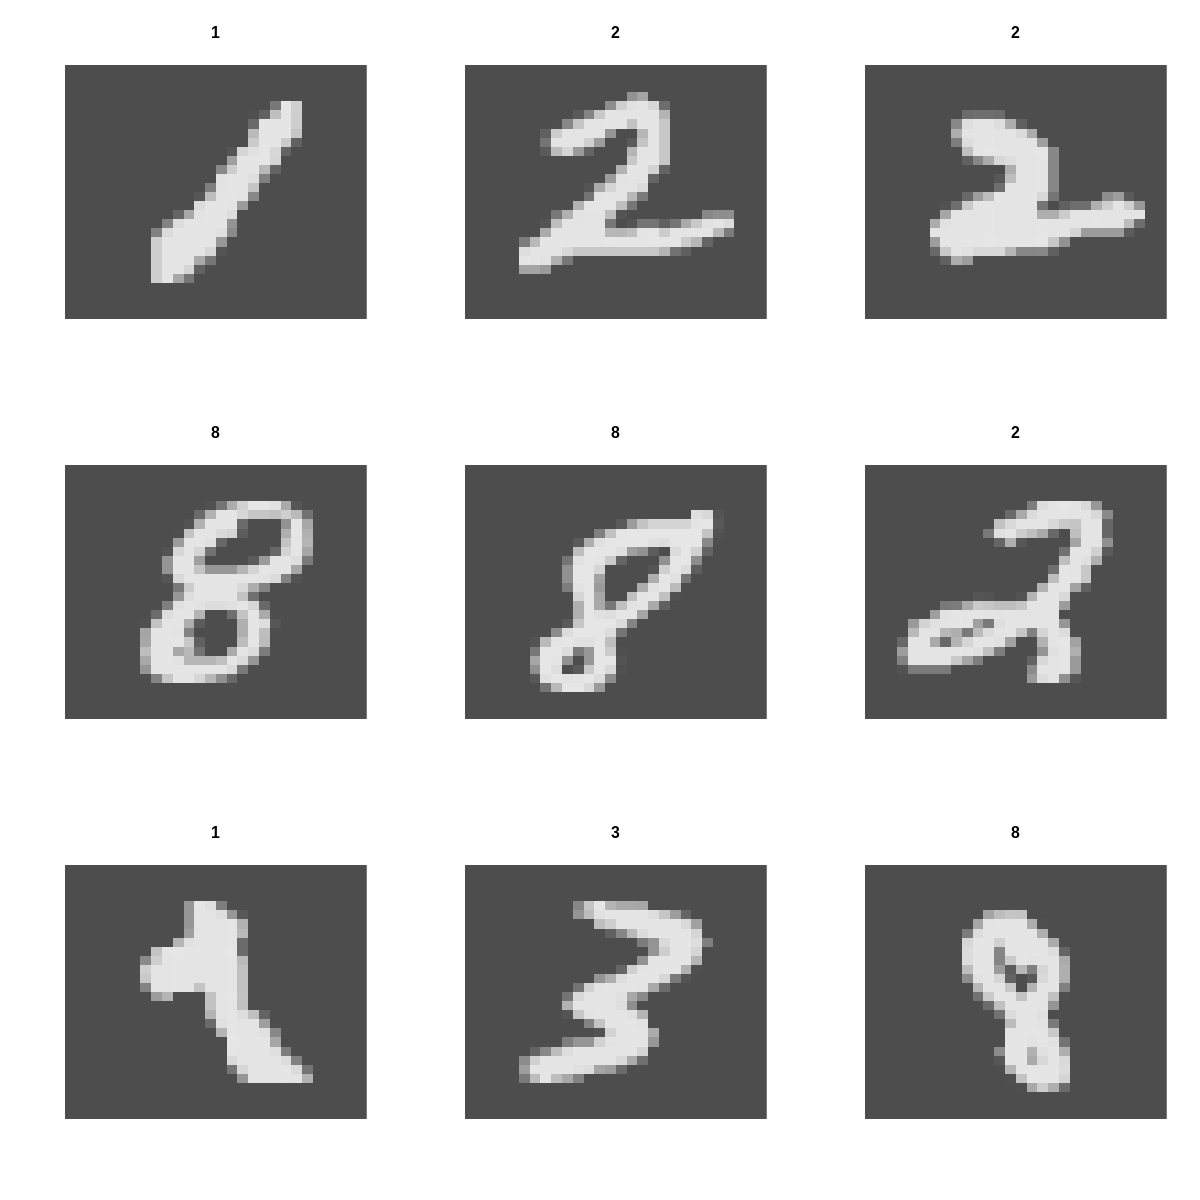

In [20]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(3,3))

for(iter in 1:9){
    i <- sample(1:length(train_ds), 1)
    x <- train_ds$data[i, ,] %>% t
    image(x[1:28, 28:1], useRaster = TRUE, axes = FALSE, col = gray.colors(1000), main = train_ds$targets[i]-1)
}

<br><br><br><br>
<br><br><br><br>


---

# Image Classification

In [21]:
train_dl <- dataloader(train_ds, batch_size = 2000, shuffle = TRUE)
test_dl <- dataloader(test_ds, batch_size = 2000)

In [22]:
NNet_10 <- nn_module(
  initialize = function(p, q1, q2, q3, o) {
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$OUTPUT <- nn_linear(q3, o)
    self$activation <- nn_relu()
  },
  forward = function(x) {
    x %>%
      self$hidden1() %>%
      self$activation() %>%
      self$hidden2() %>%
      self$activation() %>%
      self$hidden3() %>%
      self$activation() %>%
      self$OUTPUT()
  }
)

In [23]:
fit_nn <- NNet_10 %>%
    #
    # Setup the model
    #
    setup(
        loss = nn_cross_entropy_loss(),
        optimizer = optim_adam,
        metrics = list(
            luz_metric_accuracy()
        )
    ) %>%
    #
    # Set the hyperparameters
    #
    set_hparams(p=28*28, q1=256, q2=128, q3=64, o=10) %>% 
    #
    # Fit the model
    #
    fit(
        #
        # Training Data
        #
        epochs = 10,
        data = train_dl,
        # valid_data = test_dl,
        verbose=TRUE
    )

Epoch 1/10
Train metrics: Loss: 1.5332 - Acc: 0.5484
Epoch 2/10
Train metrics: Loss: 0.4189 - Acc: 0.879
Epoch 3/10
Train metrics: Loss: 0.2992 - Acc: 0.9147
Epoch 4/10
Train metrics: Loss: 0.2521 - Acc: 0.9284
Epoch 5/10
Train metrics: Loss: 0.2163 - Acc: 0.9383
Epoch 6/10
Train metrics: Loss: 0.1869 - Acc: 0.9464
Epoch 7/10
Train metrics: Loss: 0.1637 - Acc: 0.9525
Epoch 8/10
Train metrics: Loss: 0.1464 - Acc: 0.9578
Epoch 9/10
Train metrics: Loss: 0.1297 - Acc: 0.9626
Epoch 10/10
Train metrics: Loss: 0.117 - Acc: 0.9662


In [24]:
NN10_preds <- fit_nn %>% 
  predict(test_ds) %>% 
  torch_argmax(dim = 2) %>%
  as_array()

In [25]:
NN10_preds <- NN10_preds -1 

In [26]:
table(
    NN10_preds %>% as.factor(),
    (test_ds$targets-1) %>% as.factor()
)

   
       0    1    2    3    4    5    6    7    8    9
  0  968    0    8    0    1    5    7    1    5    5
  1    0 1118    1    1    0    1    3    9    3    7
  2    1    3  994   11    3    0    0   11    3    2
  3    1    2    6  967    1   17    0    2   14    9
  4    0    0    2    0  938    1    3    1    6   15
  5    2    1    1    5    0  845    6    1    3    5
  6    6    4    4    0   11    9  936    0    8    1
  7    1    0    6   11    3    1    0  991    6    6
  8    1    7    9   14    4   11    3    2  924    6
  9    0    0    1    1   21    2    0   10    2  953

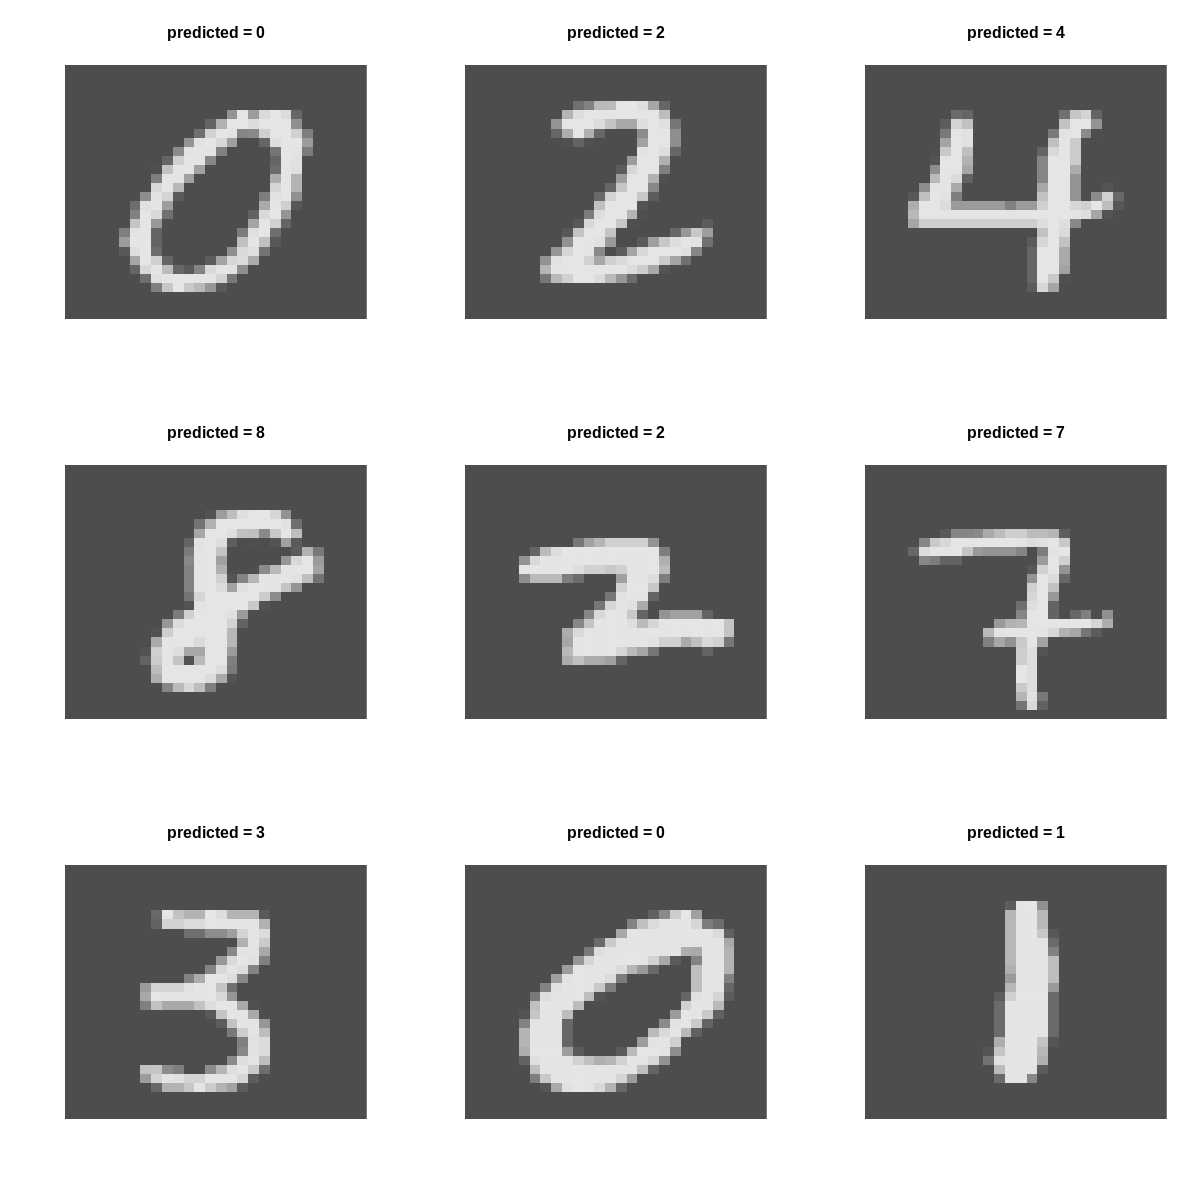

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(3,3))

for(iter in 1:9){
    i <- sample(1:length(test_ds), 1)
    x <- test_ds$data[i, ,] %>% t
    image(x[1:28, 28:1], useRaster = TRUE, axes = FALSE, col = gray.colors(1000), main = paste("predicted =", NN10_preds[i]))
}

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

---

# Thu, Apr 13


## Supervised learning

For a majority of this course we have focused on **supervised learning** where we have access to **labelled data** i.e., we are given access to the _covariates and the responses_

<br><br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1}, y_1)\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2}, y_2)\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n}, y_n)
\end{aligned}
$$

<br><br><br>

Our **goal** has been to:

* Predict $y$ using $X_1, X_2, \dots X_p$
* Understand how each $X_i$ influences the response $y$

## Unsupervised learning

In unsupervised learning we **DON'T** have access to the labelled data, i.e., we are only given:

<br><br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1})\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2})\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n})
\end{aligned}
$$

<br><br><br>

Our **goal** here is:
* To understand the relationship between $X_1, X_2, \dots X_p$
    > * **dimension reduction**: 
    > 
    > Can we discover subgroups of variables $X_1, X_2, \dots X_p$ which behave similarly?
    
    > * **clustering**:
    >
    > Can we discover subgroups of observations $1, 2, \dots n$ which are similar?
    
<br><br><br>

#### Why unsupervised learning?

It is always easier to obtain unlabeled data as oppposed to labeled data (which require someone or something to actually assign the proper responses $y_1, y_2, \dots y_n$)

In statistics and data science, there are a multitude of different methods which have been proposed to tackle each of the two problems. They include:

* **Dimension reduction**:
    * Principal component analysis
    * Uniform Manifold Approximation (UMAP)
    * t-Stochastic Neighbor embedding (t-SNE)
    * ...
    
* **Clustering**:
    * k-means clustering
    * Hierarchical clustering
    * Topological clustering
    * Laplacian eigenmaps
    * ...
    
This is one of the most exciting parts of data-science

---


## Principal Component Analysis (PCA)

Given variables $(X_1, X_2, \dots X_p)$, PCA produces a low-dimensional representation of the dataset, i.e., 

<br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1}) \longrightarrow (Z_{1, 1}, Z_{2, 1})\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2}) \longrightarrow (Z_{1, 2}, Z_{2, 2})\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n}) \longrightarrow (Z_{1, n}, Z_{2, n})
\end{aligned}
$$

<br><br>

It tries to create variables $(Z_1, Z_2, \dots Z_q)$ for $q < p$ such that:

1. $q \ll p$
1. $(Z_1, Z_2, \dots Z_q)$ contains _roughly_ the same information as $(X_1, X_2, \dots X_p)$

#### How does PCA achieve this?


---

<br><br>


##### Step 1:

The **first principal component** $Z_1$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_1 = v_{11} X_1 + v_{21} X_2 + \dots v_{p1} X_p
$$

<br><br>

such that: 
* $Z_1$ has the largest possible variance
* $\sum_{i=1}^p v^2_{p, i} = 1$

<br><br>


> #### Note:
> $V_1 = (v_{11}, v_{21}, \dots v_{p1})$ are called the **factor loadings**

<br><br>

---

<br><br>


##### Step 2:

The **second principal component** $Z_2$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_2 = v_{12} X_1 + v_{22} X_2 + \dots v_{p2} X_p
$$

<br><br>

such that: 
* $V_2 \perp V_1$
* $Z_2$ has the largest possible variance
* $\sum_{i=1}^p v^2_{p, 2} = 1$

<br><br>

---

$\vdots\\\vdots$

---

##### Step q:

The **$q$th principal component** $Z_q$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_2 = v_{12} X_1 + v_{22} X_2 + \dots v_{p2} X_p
$$

<br><br>

such that: 
* $Z_q$ has the largest possible variance
* $V_q \perp \text{span}(V_1, V_2, \dots, V_{q-1})$
* $\sum_{i=1}^p v^2_{p, 2} = 1$

<br><br>



<br><br>

## Example in `R`

In R, we can use the built-in function prcomp() to perform PCA.

In [709]:
data <- tibble(
  x1 = rnorm(100, mean = 0, sd = 1),
  x2 = x1 + rnorm(100, mean = 0, sd = 0.1),
  x3 = x1 + rnorm(100, mean = 0, sd = 0.1)
)

head(data)

x1,x2,x3
<dbl>,<dbl>,<dbl>
1.53415249,1.54082085,1.4096063
-1.05419254,-0.98938884,-1.0716182
-0.03324191,-0.09015295,-0.1860059
0.94549011,0.88573245,0.9427549
0.23925835,0.34193964,0.2382732
1.55987742,1.72789515,1.5964940


In [710]:
pca <- princomp(data, cor = TRUE)
summary(pca)

Importance of components:
                          Comp.1      Comp.2      Comp.3
Standard deviation     1.7287109 0.092155914 0.055369621
Proportion of Variance 0.9961472 0.002830904 0.001021932
Cumulative Proportion  0.9961472 0.998978068 1.000000000

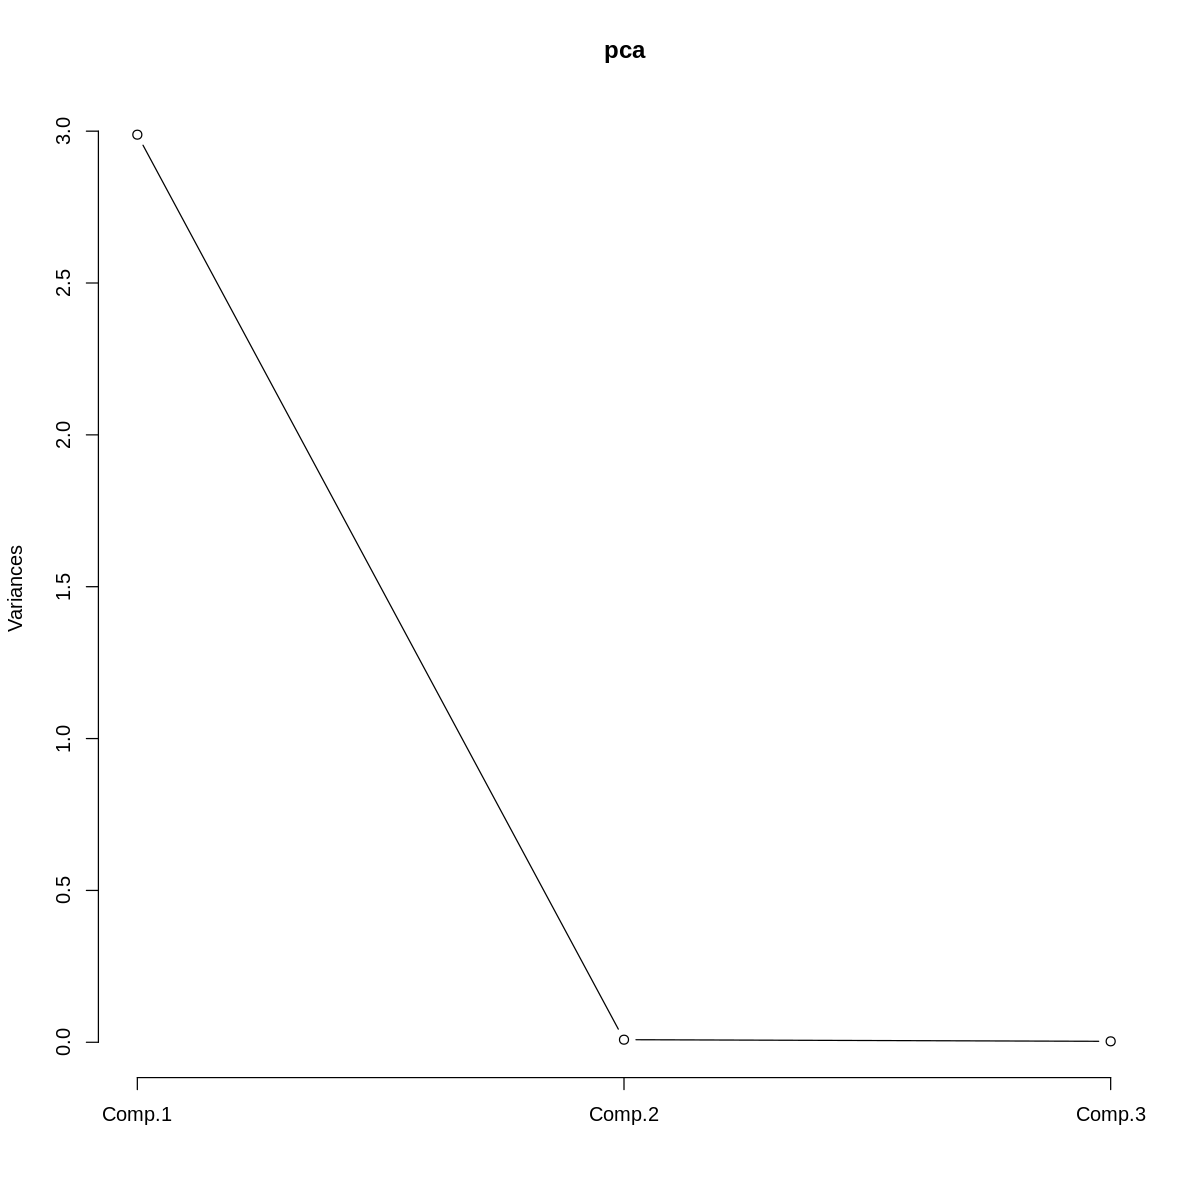

In [711]:
screeplot(pca, type="l")

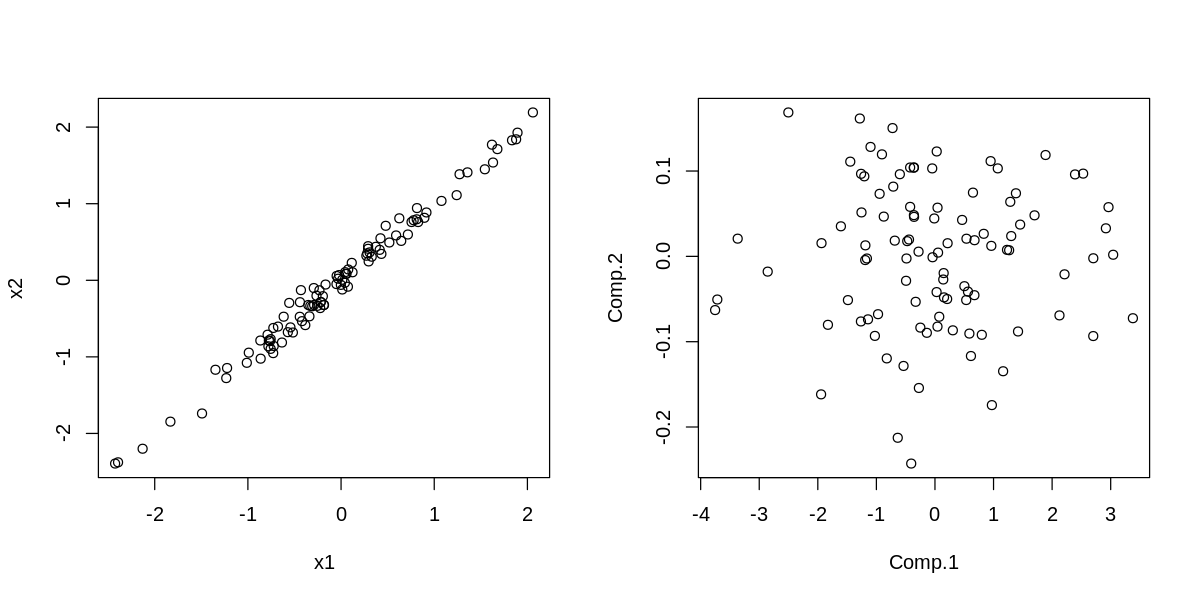

In [108]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1, 2))

Z_pca <- predict(pca, data[, 1:2])
plot(data)
plot(Z_pca)

In [712]:
pca$loadings


Loadings:
   Comp.1 Comp.2 Comp.3
x1  0.578  0.111  0.809
x2  0.577  0.645 -0.501
x3  0.577 -0.756 -0.308

               Comp.1 Comp.2 Comp.3
SS loadings     1.000  1.000  1.000
Proportion Var  0.333  0.333  0.333
Cumulative Var  0.333  0.667  1.000

---



### Interpretation of principal components



In [763]:
set.seed(42)

n <- 500
science <- rnorm(n, mean = 60, sd = 10)
humanities <- rnorm(n, mean = 80, sd=10)

df <- tibble(
  math = 0.8 * science + rnorm(n, mean = 0, sd = 7),
  physics = 1.0 * science + rnorm(n, mean = 0, sd = 5),
  chemistry = 1.3 * science + rnorm(n, mean = 0, sd = 3),
  history = 0.8 * humanities + rnorm(n, mean = 0, sd = 5),
  geography = 1.0 * humanities + rnorm(n, mean = 0, sd = 10),
  literature = 1.2 * humanities + rnorm(n, mean = 0, sd = 2)
)

In [764]:
head(df)

math,physics,chemistry,history,geography,literature
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75.24308,70.70267,96.57419,75.31981,83.43479,108.93056
47.15127,53.67394,69.82515,71.29549,81.22060,104.36971
57.70016,58.69492,77.54646,63.52407,75.90540,95.74232
55.70171,70.48825,80.20710,67.08787,69.87339,97.44619
44.26261,60.06739,79.38006,61.18328,83.95607,87.11304
42.96862,60.64108,77.71790,62.33062,69.22419,91.85589


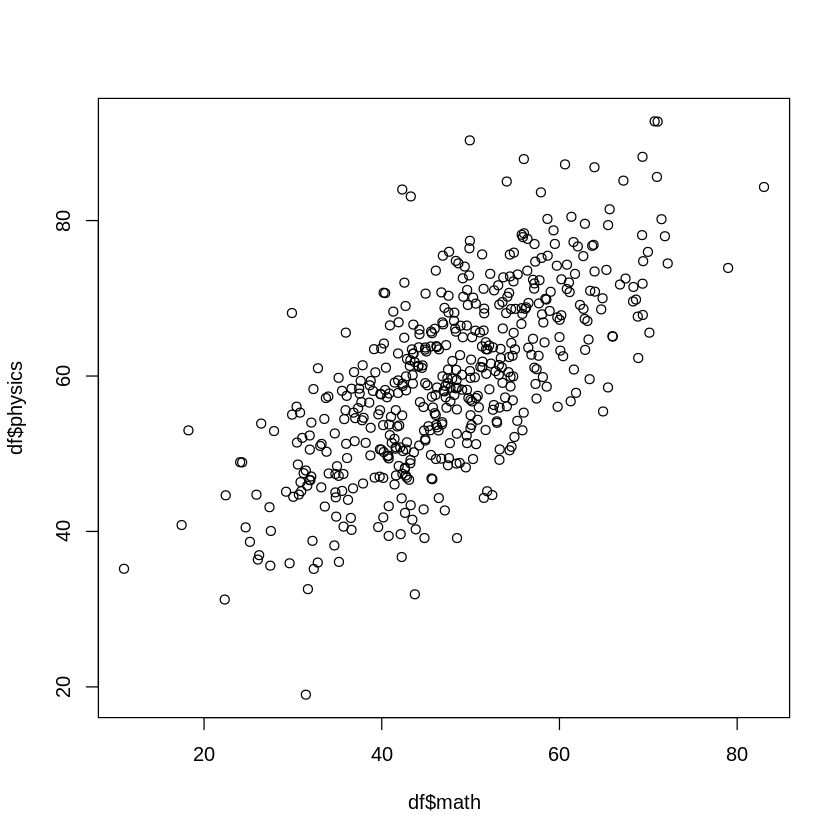

In [736]:
options(repr.plot.width=7, repr.plot.height=7)
plot(df$math, df$physics)

In [739]:
pca <- princomp(df, cor=TRUE)
summary(pca)

Importance of components:
                          Comp.1    Comp.2     Comp.3     Comp.4    Comp.5
Standard deviation     1.6126627 1.5502164 0.64119185 0.57392877 0.3702848
Proportion of Variance 0.4334468 0.4005285 0.06852116 0.05489904 0.0228518
Cumulative Proportion  0.4334468 0.8339753 0.90249648 0.95739552 0.9802473
                           Comp.6
Standard deviation     0.34426163
Proportion of Variance 0.01975268
Cumulative Proportion  1.00000000

In [744]:
pca$loadings


Loadings:
           Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
math        0.482  0.269         0.813         0.180
physics     0.501  0.294        -0.528  0.116  0.606
chemistry   0.517  0.301        -0.235 -0.124 -0.756
history    -0.287  0.509  0.521         0.615       
geography  -0.280  0.463 -0.819         0.176       
literature -0.299  0.527  0.230        -0.750  0.133

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.167  0.167  0.167  0.167  0.167  0.167
Cumulative Var  0.167  0.333  0.500  0.667  0.833  1.000

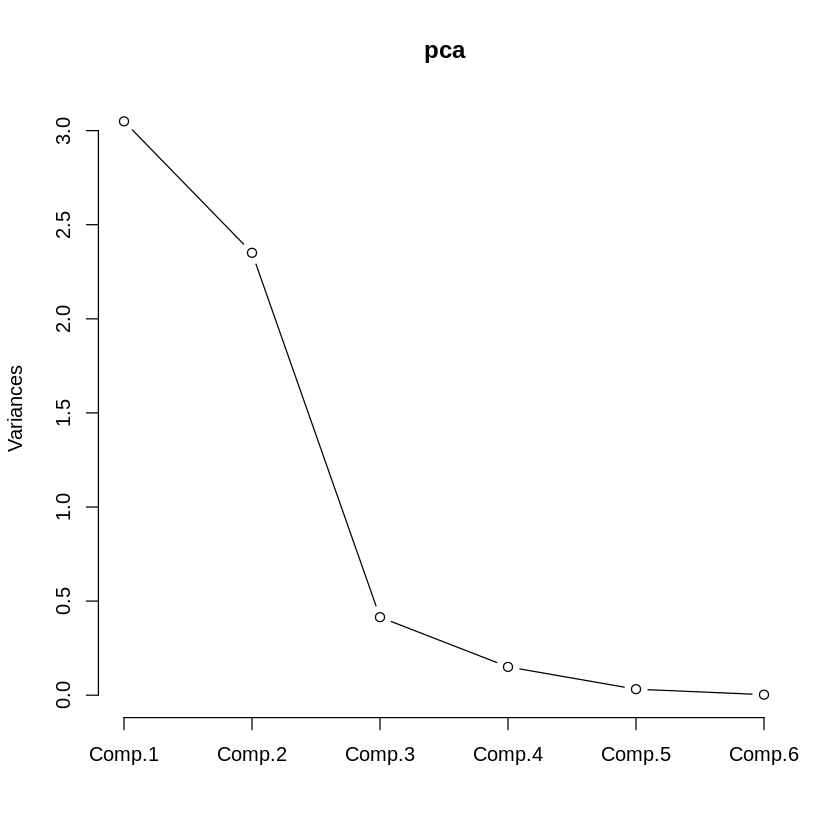

In [724]:
plot(pca, type="l")

---

#### Principal component regression

In [745]:
df$gpa <- (0.9 * science + 0.5 * humanities + rnorm(n, mean=0, sd=10)) * 4 / 100

In [746]:
head(df)

math,physics,chemistry,history,geography,literature,gpa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52.11142,58.28909,76.06157,63.31655,85.41011,100.71987,3.296984
37.70540,56.64673,69.26708,52.89057,64.18282,80.34539,2.896778
47.28587,55.91768,75.62115,58.15083,61.61164,94.44828,3.427857
43.24067,49.19334,64.19820,67.41593,59.00333,95.68437,2.868418
59.75596,67.55684,89.51709,59.04422,65.85631,95.70708,4.583466
40.22147,50.21481,64.77461,58.63584,74.82527,85.36651,2.914951


In [747]:
lm_fit <- lm(gpa ~ ., df)
summary(lm_fit)


Call:
lm(formula = gpa ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46866 -0.09875 -0.00031  0.09366  0.55475 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.2010731  0.0694107 -31.711  < 2e-16 ***
math         0.0047228  0.0009913   4.764  2.5e-06 ***
physics      0.0112692  0.0012286   9.172  < 2e-16 ***
chemistry    0.0446224  0.0011814  37.771  < 2e-16 ***
history      0.0028388  0.0013384   2.121  0.03442 *  
geography    0.0017951  0.0006832   2.627  0.00887 ** 
literature   0.0131162  0.0012294  10.669  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1537 on 493 degrees of freedom
Multiple R-squared:  0.9622,	Adjusted R-squared:  0.9618 
F-statistic:  2094 on 6 and 493 DF,  p-value: < 2.2e-16


In [748]:
vif(lm_fit) %>% t

math,physics,chemistry,history,geography,literature
2.405862,4.180321,5.244268,3.637173,2.003579,4.528687


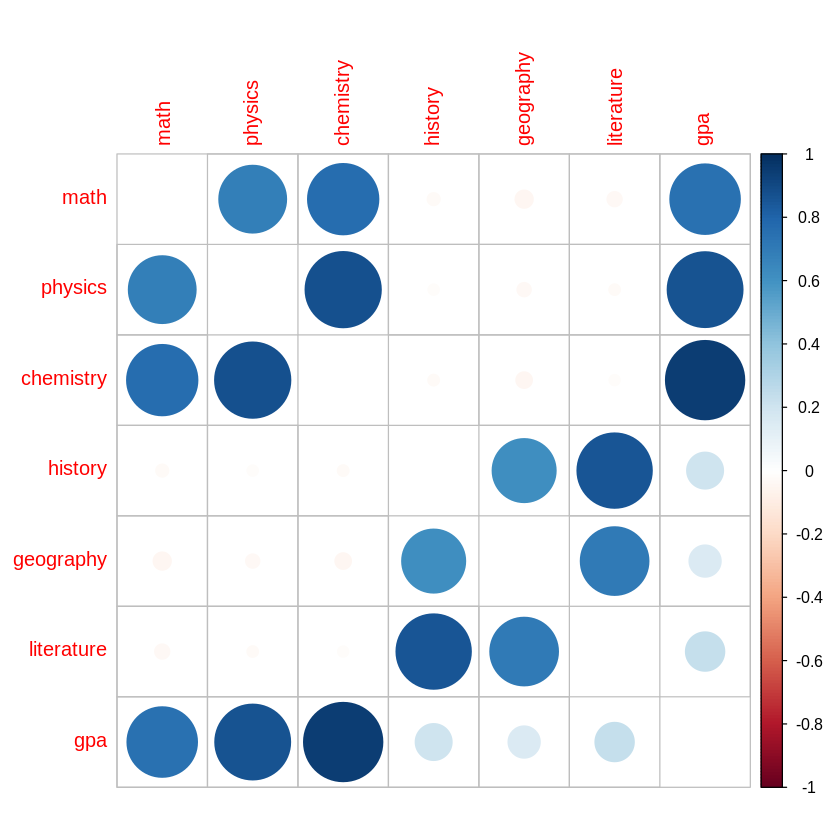

In [749]:
df %>% 
    # select(-gpa) %>% 
    cor() %>% 
    corrplot(diag=F)

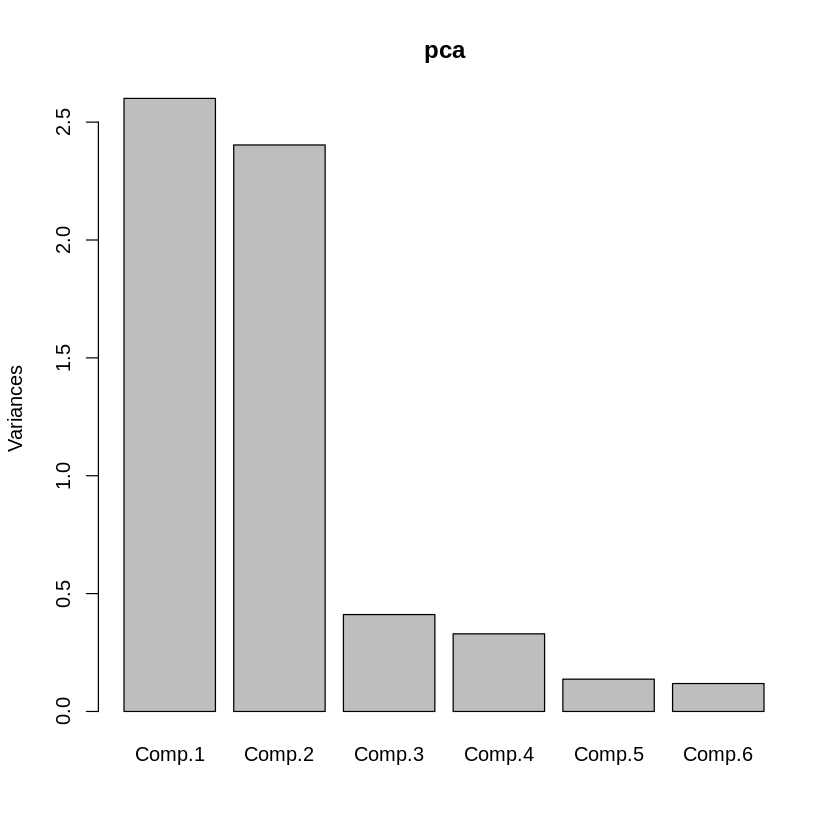

In [750]:
pca <- princomp(df %>% select(-gpa), cor=TRUE)
screeplot(pca)

In [753]:
Z <- predict(pca, df)

df_pca <- Z %>% 
    as_tibble %>% 
    select(Comp.1, Comp.2) %>% 
    mutate(gpa = df$gpa)

head(df_pca)

Comp.1,Comp.2,gpa
<dbl>,<dbl>,<dbl>
-0.1215295,0.40571176,3.296984
0.1325099,-2.28466315,2.896778
0.3180265,-1.10588595,3.427857
-0.8521039,-1.18739325,2.868418
1.7843981,0.06039576,4.583466
-0.7146190,-1.62205353,2.914951


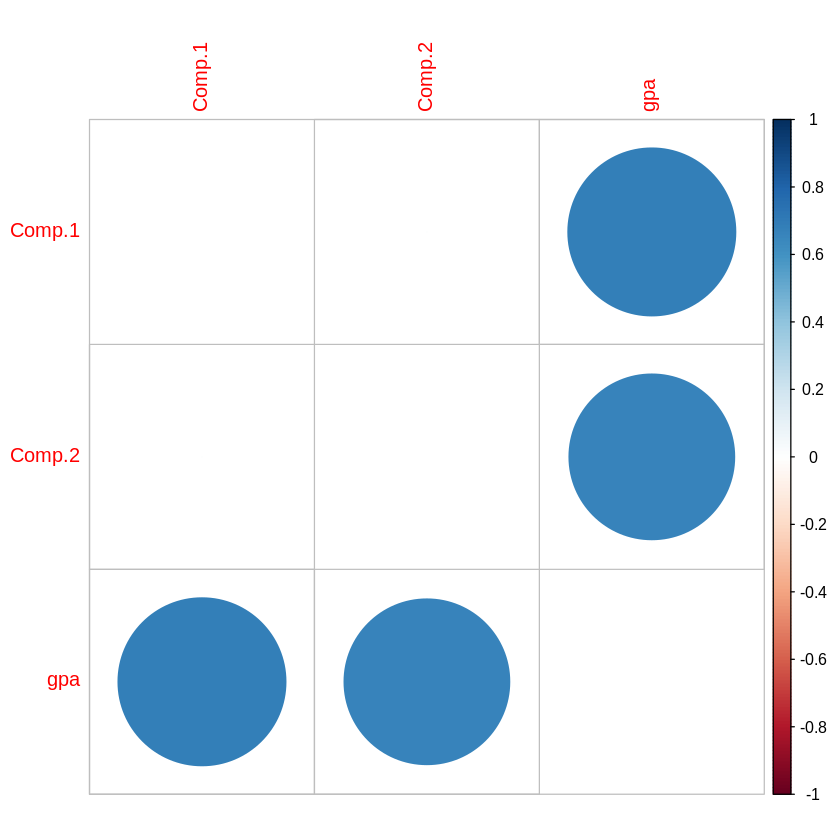

In [754]:
df_pca %>% 
    cor() %>% 
    corrplot(diag=F)

In [755]:
lm_pca <- lm(gpa ~ ., df_pca)
summary(lm_pca)


Call:
lm(formula = gpa ~ ., data = df_pca)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.77782 -0.13634  0.01268  0.14557  0.72094 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.735814   0.010052  371.65   <2e-16 ***
Comp.1      0.334363   0.006233   53.64   <2e-16 ***
Comp.2      0.338625   0.006484   52.22   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2248 on 497 degrees of freedom
Multiple R-squared:  0.9185,	Adjusted R-squared:  0.9182 
F-statistic:  2802 on 2 and 497 DF,  p-value: < 2.2e-16


In [756]:
vif(lm_pca) %>% t

Comp.1,Comp.2
1,1


----

# Nonlinear dimension reduction

In [297]:
generate_two_spirals <- function(){
  set.seed(42)
  n <- 500
  noise <- 0.05
  t <- (1:n) / n * 4 * pi
  x1 <- t * (sin(t) + rnorm(n, 0, noise))
  x2 <- t * (cos(t) + rnorm(n, 0, noise))
  y  <- t
  return(tibble(x1=x1, x2=x2, y=y))
}

In [298]:
df <- generate_two_spirals()
head(df)

x1,x2,y
<dbl>,<dbl>,<dbl>
0.002354385,0.02641806,0.02513274
0.001106314,0.05250107,0.05026548
0.007048469,0.07517475,0.07539822
0.013270574,0.10070704,0.10053096
0.018289931,0.12014795,0.12566371
0.021853325,0.14759135,0.15079645


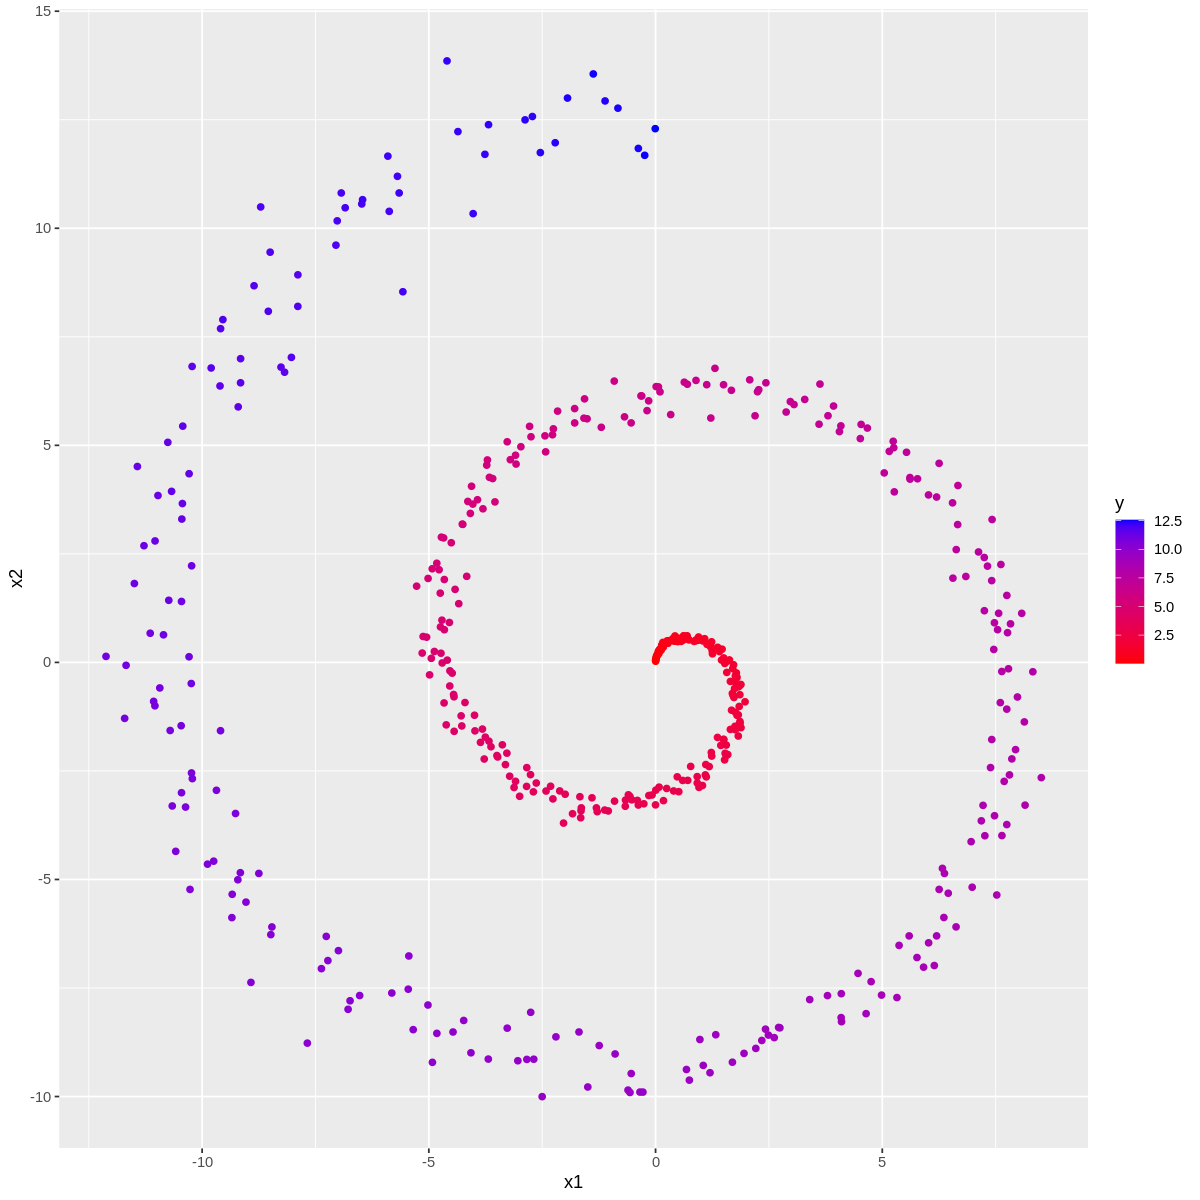

In [299]:
ggplot(df) +
    geom_point(aes(x=x1, y=x2, col=y)) +
    scale_colour_gradient(low="red", high="blue")

In [300]:
pca <- princomp(df[, 1:2], cor=T)

In [655]:
pca$loadings


Loadings:
   Comp.1 Comp.2
x1  0.707  0.707
x2 -0.707  0.707

               Comp.1 Comp.2
SS loadings       1.0    1.0
Proportion Var    0.5    0.5
Cumulative Var    0.5    1.0

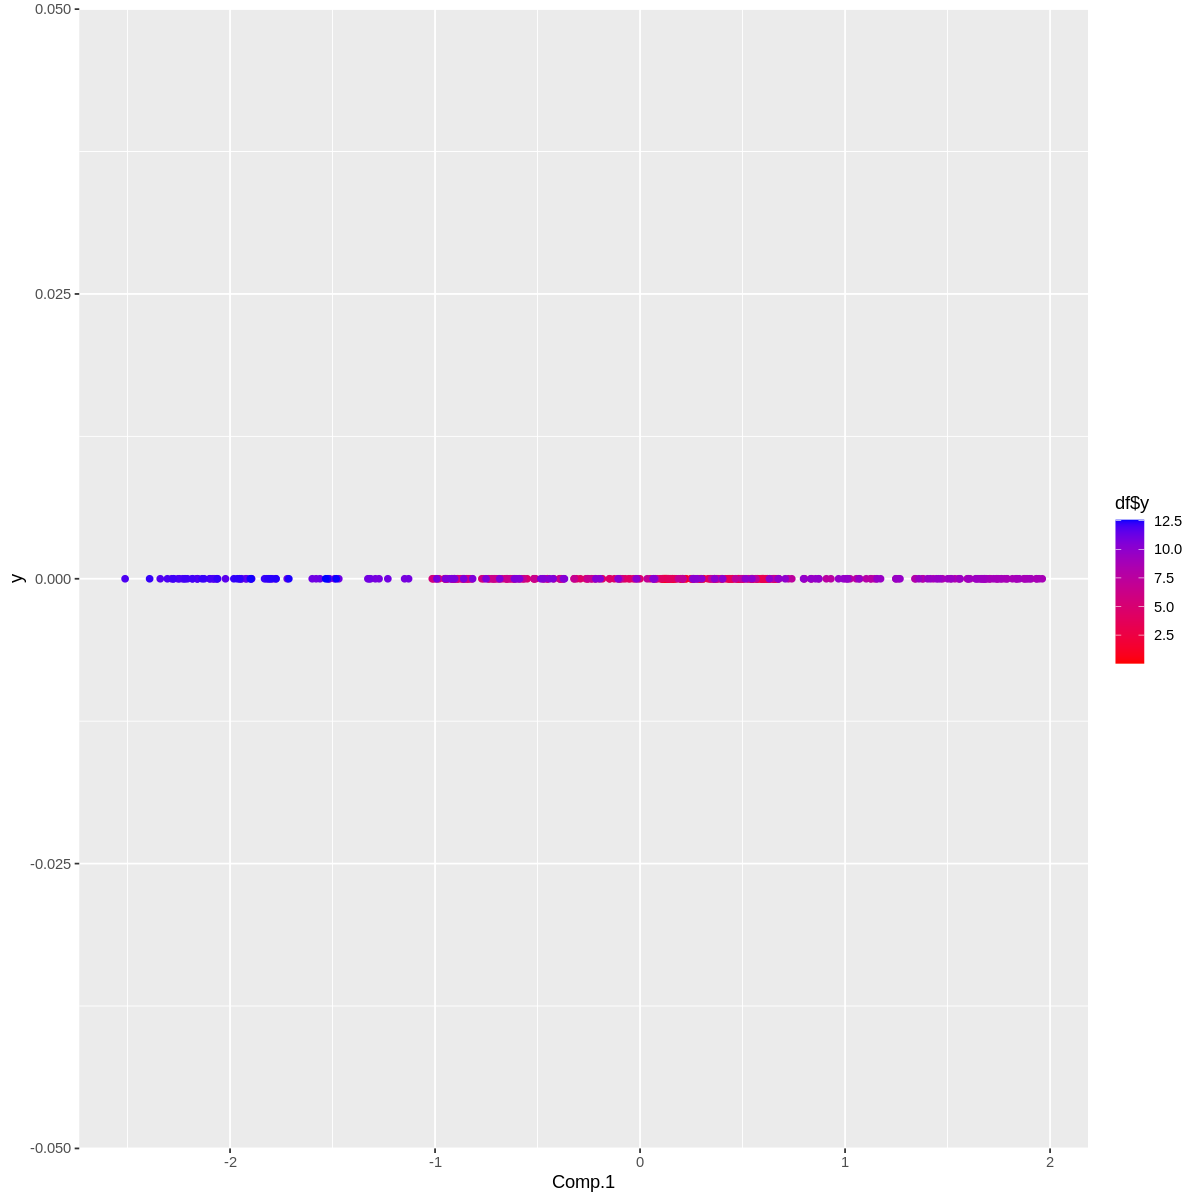

In [301]:
df_pca <- predict(pca, df)

ggplot(as_tibble(df_pca)) +
    geom_point(aes(x=Comp.1, y=0, col=df$y)) +
    scale_colour_gradient(low="red", high="blue")

In [302]:
library(RDRToolbox)

In [303]:
isomap <- Isomap(df[, 1:2] %>% as.matrix, dims=1)

Computing distance matrix ... 
done

Building graph with shortest paths (using 5 nearest neighbours) ... 
done

Computing low dimensional embedding ... 
done

number of samples: 500

reduction from 2 to 1 dimensions

number of connected components in graph: 1



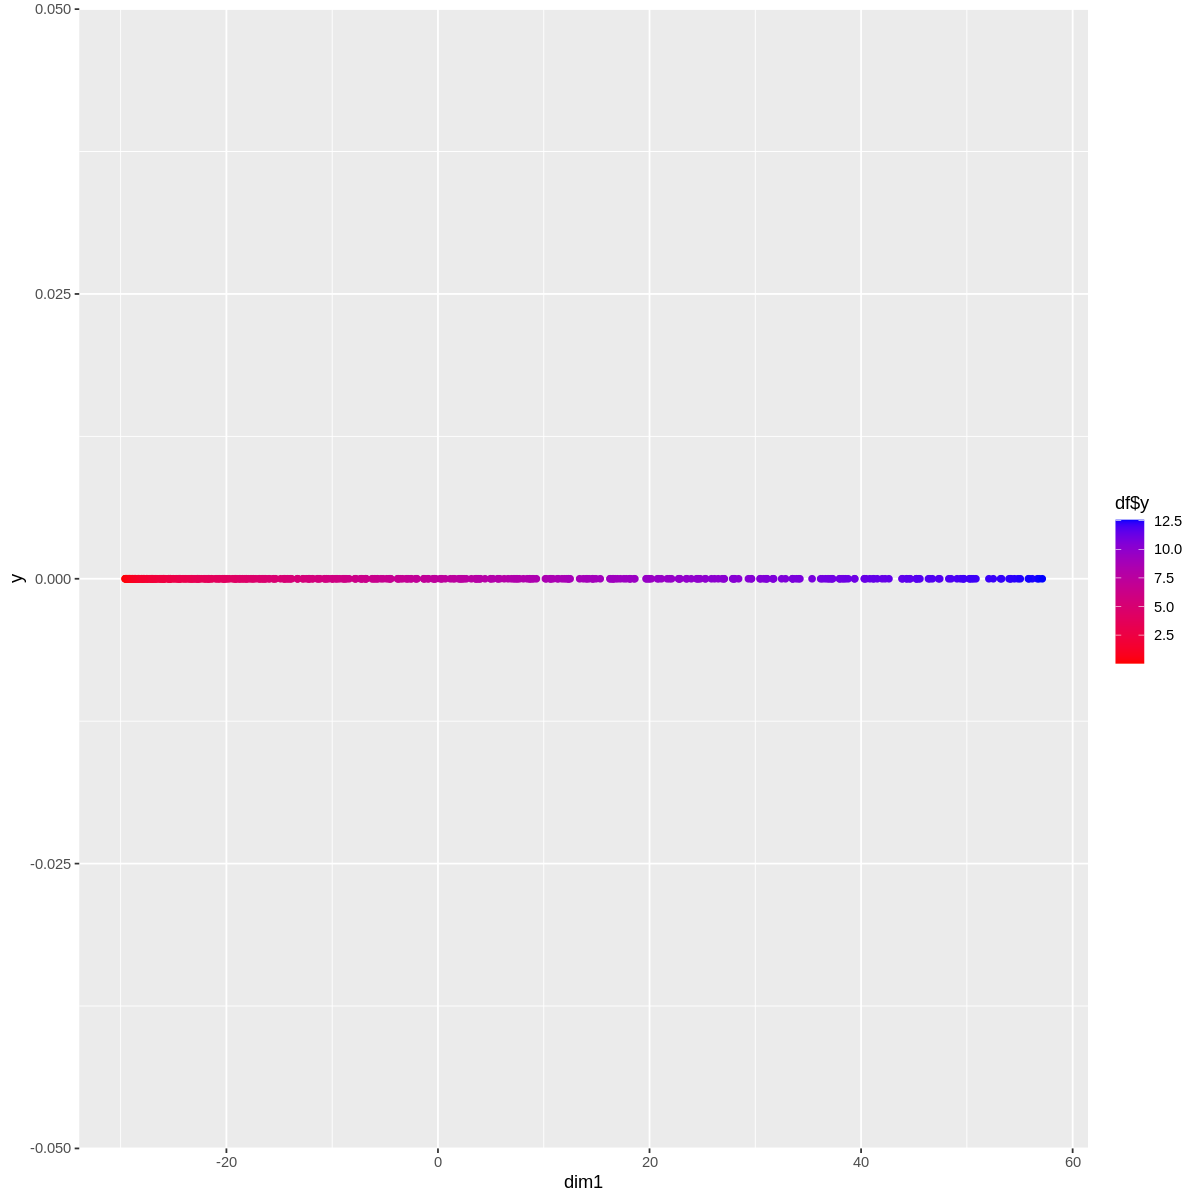

In [304]:
ggplot(as_tibble(isomap)) +
    geom_point(aes(x=dim1, y=0, col=df$y)) +
    scale_colour_gradient(low="red", high="blue")

---

# Autoencoder


![Autoencoder](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*ydTBLRhllAgnqXUO5CSonQ.png)


[image source](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*ydTBLRhllAgnqXUO5CSonQ.png)

In [676]:
autoencoder <- nn_module(
    initialize = function(p, q1, q2, q3, q4, o) {
    self$encoder <- nn_sequential(
        nn_linear(p, q1), nn_relu(),
        nn_linear(q1, q2), nn_relu(),
        nn_linear(q2, q3), nn_relu(),
        nn_linear(q3, q4), nn_relu(),
        nn_linear(q4, o)
    )
    self$decoder <- nn_sequential(
        nn_linear(o, q4), nn_relu(),
        nn_linear(q4, q3), nn_relu(),
        nn_linear(q3, q2), nn_relu(),
        nn_linear(q2, q1), nn_relu(),
        nn_linear(q1, p)
    )
    },
    forward = function(x) {
    x %>%
        torch_reshape(c(-1, 28 * 28)) %>% 
        self$encoder() %>%
        self$decoder() %>% 
        torch_reshape(c(-1, 28, 28))
    },
    predict = function(x) {
    x %>% 
        torch_reshape(c(-1, 28 * 28)) %>% 
        self$encoder()     
    }
)

In [677]:
X <- test_ds
inputs <- torch_tensor(X$data * 1.0)
AE <- autoencoder(p=28*28, q1=32, q2=16, q3=8, q4=4, o=2)

In [678]:
plot_image = \(x) image(t(x)[1:28, 28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000))

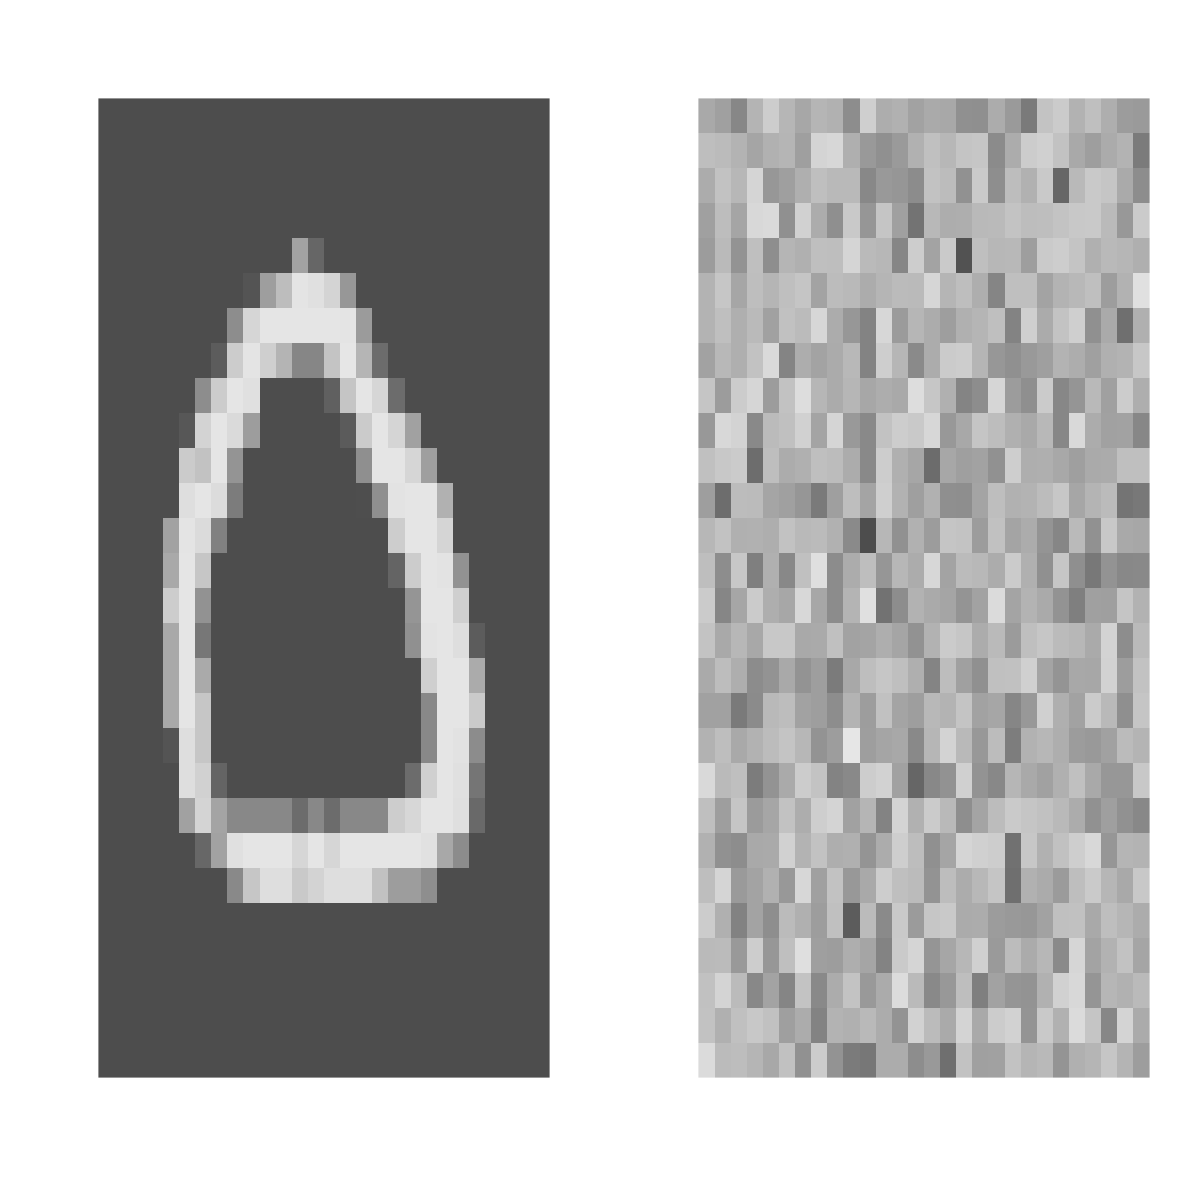

In [682]:
i <- sample(1:10000, 1)

input <- inputs[i]
output <- AE(inputs[i:i])[1]

par(mfrow=c(1, 2))
plot_image(inputs[i] %>% as_array)
plot_image(output %>% as_array)

In [762]:
ae_fit <- autoencoder %>%
    setup(
        loss = nn_mse_loss(),
        optimizer = optim_adam
    ) %>%

    set_hparams(
        p=28*28, q1=2048, q2=1024, q3=512, q4=256, o=2
    ) %>%
    
    set_opt_hparams(
        lr=1e-3
    ) %>% 

    fit(
        data = list(inputs, inputs),
        epochs=20,
        verbose=TRUE,
        dataloader_options = list(batch_size = 1000, shuffle=TRUE)
    )

Epoch 1/20
Train metrics: Loss: 6381.8181
Epoch 2/20
Train metrics: Loss: 7056.7561
Epoch 3/20
Train metrics: Loss: 4890.8272
Epoch 4/20
Train metrics: Loss: 4328.1896
Epoch 5/20
Train metrics: Loss: 4178.121
Epoch 6/20
Train metrics: Loss: 4142.5384
Epoch 7/20
Train metrics: Loss: 4130.8954
Epoch 8/20
Train metrics: Loss: 4126.646
Epoch 9/20
Train metrics: Loss: 4124.7846
Epoch 10/20
Train metrics: Loss: 4123.9394
Epoch 11/20
Train metrics: Loss: 4123.5617
Epoch 12/20
Train metrics: Loss: 4123.5095
Epoch 13/20
Train metrics: Loss: 4123.1918
Epoch 14/20
Train metrics: Loss: 4123.2229
Epoch 15/20
Train metrics: Loss: 4123.1403
Epoch 16/20
Train metrics: Loss: 4123.075
Epoch 17/20
Train metrics: Loss: 4123.2171
Epoch 18/20
Train metrics: Loss: 4123.1215
Epoch 19/20
Train metrics: Loss: 4123.1656
Epoch 20/20
Train metrics: Loss: 4123.1754


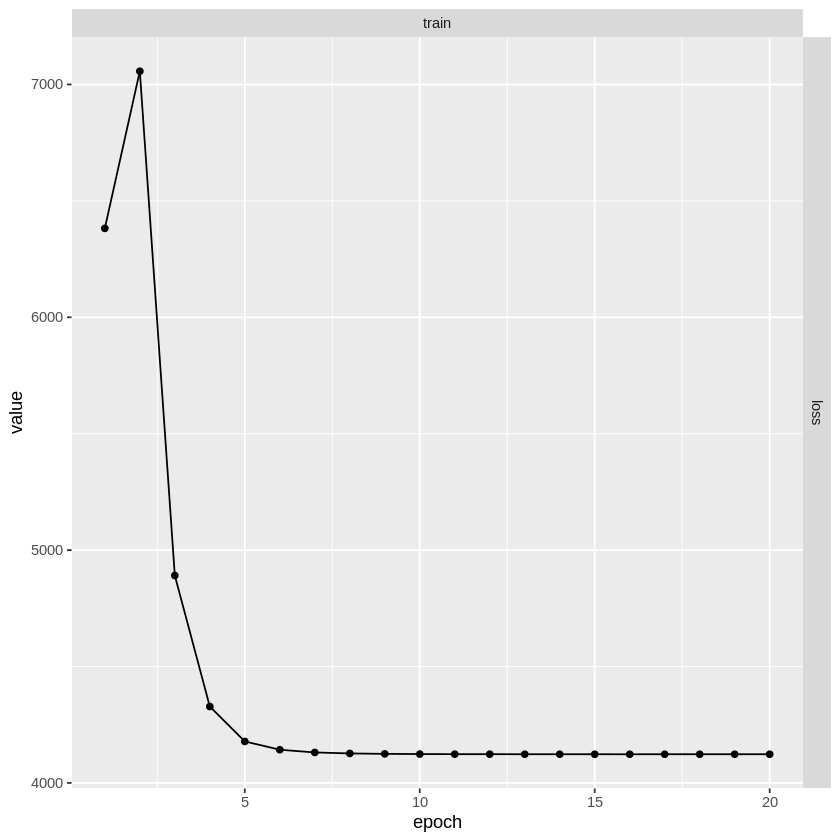

In [765]:
plot(ae_fit)

In [766]:
X_dim2 <- predict(ae_fit, inputs) %>% as_array()
head(X_dim2)

50.31117,-2.563267
62.09777,-2.363968
29.56050,-1.376087
105.27750,-4.508119
50.72242,-2.150302
43.29389,-2.130720


In [767]:
df_ae <- tibble(
    x1 = X_dim2[, 1],
    x2 = X_dim2[, 2],
    y = as.factor(X$targets - 1)
)

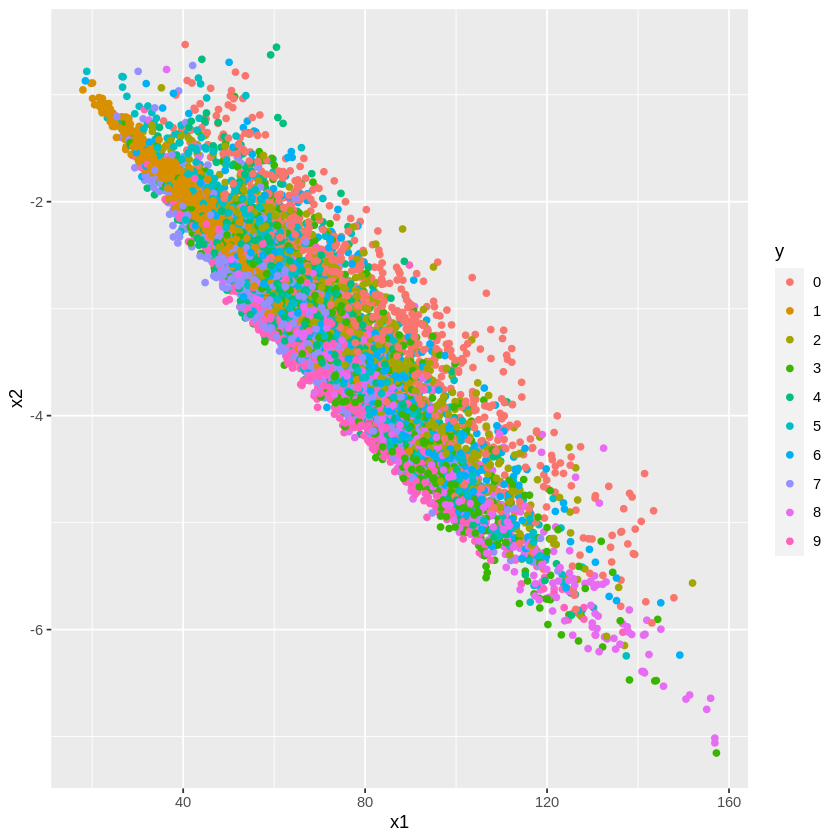

In [768]:
ggplot(df_ae) +
    geom_point(aes(x=x1, y=x2, col=y))